In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from medmnist import VesselMNIST3D
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load test data
test_dataset = VesselMNIST3D(split='test', size=28, download=True)
testx = np.array([test_dataset[i][0] for i in range(len(test_dataset))])
testy = np.array([test_dataset[i][1][0] for i in range(len(test_dataset))])

# Reshape for TensorFlow (channels last)
testx = np.transpose(testx, (0, 2, 3, 4, 1))  # (N, 28, 28, 28, 1)

# Load ensemble models
model_dir = "models/ensemble_models/ensemble_models"
model_files = [
    "model_seed_42.keras",
    "model_seed_123.keras",
    "model_seed_456.keras",
    "model_seed_789.keras",
    "model_seed_1010.keras"
]

ensemble_models = []
for f in model_files:
    path = os.path.join(model_dir, f)
    if os.path.exists(path):
        model = keras.models.load_model(path, compile=False)
        ensemble_models.append(model)
        print(f"Loaded: {f}")
    else:
        print(f"Not found: {f}")

print(f"\nLoaded {len(ensemble_models)} models")

# Generate ensemble predictions
all_preds = []
for i, model in enumerate(ensemble_models):
    preds = model.predict(testx, verbose=0)
    all_preds.append(preds.flatten())
    print(f"Model {i+1} AUC: {roc_auc_score(testy, preds.flatten()):.4f}")

# Average predictions
ensemble_preds = np.mean(all_preds, axis=0)
ensemble_auc = roc_auc_score(testy, ensemble_preds)

# Find optimal threshold
best_thresh, best_f1 = 0.5, 0
for thresh in np.arange(0.3, 0.7, 0.02):
    y_pred = (ensemble_preds >= thresh).astype(int)
    tp = np.sum((y_pred == 1) & (testy == 1))
    fp = np.sum((y_pred == 1) & (testy == 0))
    fn = np.sum((y_pred == 0) & (testy == 1))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh

# Final results
y_pred_final = (ensemble_preds >= best_thresh).astype(int)

print("\n" + "="*60)
print("ENSEMBLE BENCHMARK RESULTS")
print("="*60)
print(f"ROC-AUC: {ensemble_auc:.4f}")
print(f"Best Threshold: {best_thresh:.2f}")
print(f"\nClassification Report:")
print(classification_report(testy, y_pred_final, target_names=['Healthy', 'Aneurysm']))
print("Confusion Matrix:")
print(confusion_matrix(testy, y_pred_final))

# Also benchmark the single best model with TTA if it exists
tta_path = "models/best_model_withTTA_1.keras"
if os.path.exists(tta_path):
    print("\n" + "="*60)
    print("SINGLE MODEL (with TTA) RESULTS")
    print("="*60)
    tta_model = keras.models.load_model(tta_path, compile=False)
    tta_preds = tta_model.predict(testx, verbose=0).flatten()
    print(f"ROC-AUC: {roc_auc_score(testy, tta_preds):.4f}")
    y_pred_tta = (tta_preds >= 0.5).astype(int)
    print(classification_report(testy, y_pred_tta, target_names=['Healthy', 'Aneurysm']))

Loaded: model_seed_42.keras
Loaded: model_seed_123.keras
Loaded: model_seed_456.keras
Loaded: model_seed_789.keras
Loaded: model_seed_1010.keras

Loaded 5 models
Model 1 AUC: 0.8247
Model 2 AUC: 0.8283
Model 3 AUC: 0.8321
Model 4 AUC: 0.8486
Model 5 AUC: 0.7972

ENSEMBLE BENCHMARK RESULTS
ROC-AUC: 0.8642
Best Threshold: 0.52

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.92      0.93       339
    Aneurysm       0.46      0.56      0.51        43

    accuracy                           0.88       382
   macro avg       0.70      0.74      0.72       382
weighted avg       0.89      0.88      0.88       382

Confusion Matrix:
[[311  28]
 [ 19  24]]

SINGLE MODEL (with TTA) RESULTS
ROC-AUC: 0.8247
              precision    recall  f1-score   support

     Healthy       0.89      1.00      0.94       339
    Aneurysm       0.00      0.00      0.00        43

    accuracy                           0.89       382
   macro avg  

c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

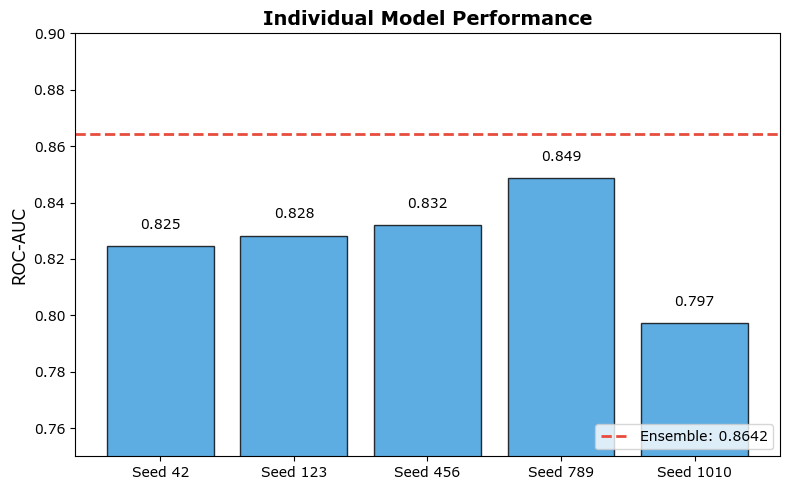

In [9]:


model_names = ['Seed 42', 'Seed 123', 'Seed 456', 'Seed 789', 'Seed 1010']
model_aucs = [0.8247, 0.8283, 0.8321, 0.8486, 0.7972]
ensemble_auc = 0.8642

# Official MedMNIST benchmarks + models
benchmark_methods = ['ResNet-18+2.5D', 'ResNet-18+3D', 'ResNet-18+ACS', 
                     'ResNet-50+3D', 'auto-sklearn', 'Baseline (Seed 42)', 'Final Model (Ensemble)']
benchmark_aucs = [0.748, 0.874, 0.930, 0.907, 0.910, 0.8247, 0.8642]
benchmark_accs = [0.846, 0.877, 0.928, 0.918, 0.915, 0.82, 0.88]

# ============================================================
# 1. Individual Model AUCs
# ============================================================
plt.figure(figsize=(8, 5))
colors = ['#3498db'] * 5
bars = plt.bar(model_names, model_aucs, color=colors, edgecolor='black', alpha=0.8)
plt.axhline(y=ensemble_auc, color='#e74c3c', linestyle='--', linewidth=2, 
            label=f'Ensemble: {ensemble_auc:.4f}')
plt.ylabel('ROC-AUC', fontsize=12)
plt.title('Individual Model Performance', fontsize=14, fontweight='bold')
plt.ylim(0.75, 0.90)
plt.legend(loc='lower right')
for bar, auc in zip(bars, model_aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{auc:.3f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
# plt.savefig('1_individual_models.png', dpi=150)
plt.show()



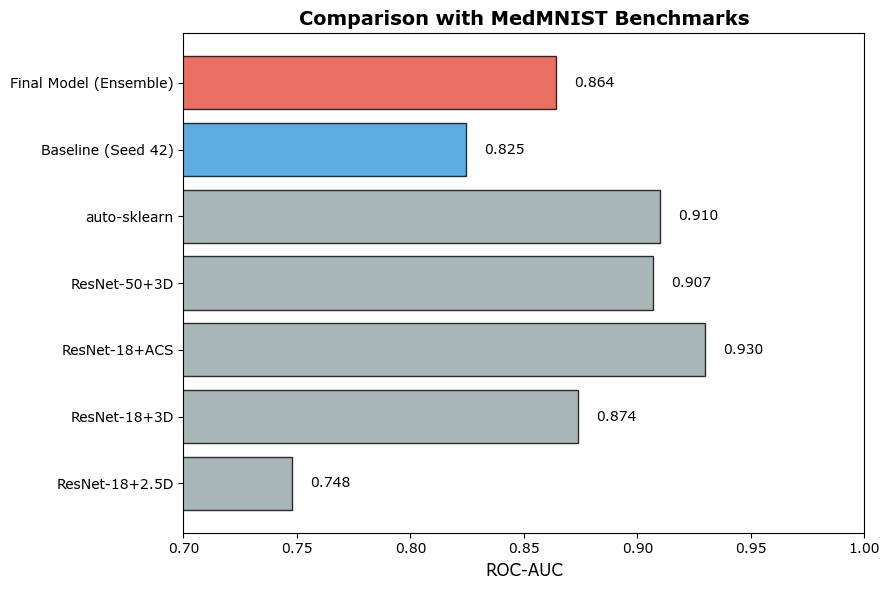

In [10]:
# ============================================================
# 2. Comparison with Official Benchmarks (Updated)
# ============================================================
plt.figure(figsize=(9, 6))
colors2 = ['#95a5a6'] * 5 + ['#3498db', '#e74c3c']  # Gray for official, blue for baseline, red for final
bars2 = plt.barh(benchmark_methods, benchmark_aucs, color=colors2, edgecolor='black', alpha=0.8)
plt.xlabel('ROC-AUC', fontsize=12)
plt.title('Comparison with MedMNIST Benchmarks', fontsize=14, fontweight='bold')
plt.xlim(0.7, 1.0)
for bar, auc in zip(bars2, benchmark_aucs):
    plt.text(auc + 0.008, bar.get_y() + bar.get_height()/2, 
             f'{auc:.3f}', ha='left', va='center', fontsize=10)
plt.tight_layout()
# plt.savefig('2_benchmark_comparison.png', dpi=150)
plt.show()


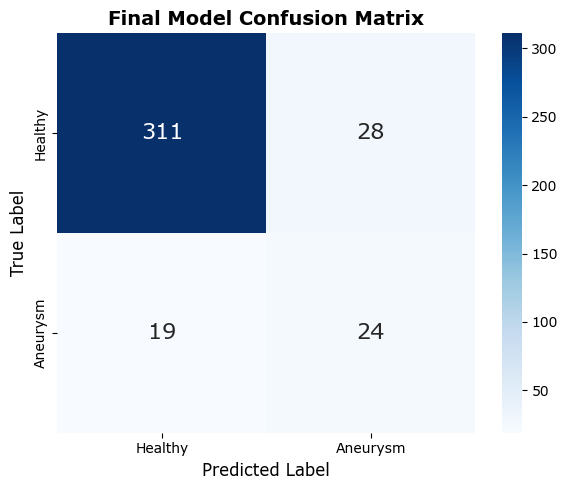

In [11]:

# ============================================================
# 3. Confusion Matrix
# ============================================================
plt.figure(figsize=(6, 5))
cm = np.array([[311, 28], [19, 24]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'],
            annot_kws={'size': 16})
plt.title('Final Model Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
# plt.savefig('3_confusion_matrix.png', dpi=150)
plt.show()



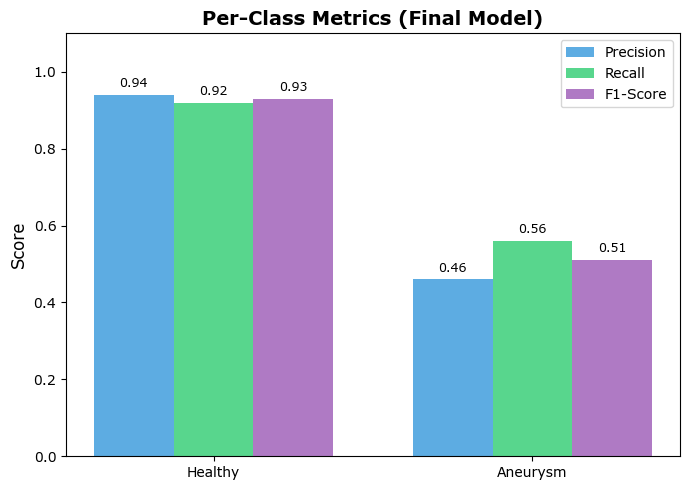

In [12]:
# ============================================================
# 4. Per-Class Metrics
# ============================================================
plt.figure(figsize=(7, 5))
classes = ['Healthy', 'Aneurysm']
precision = [0.94, 0.46]
recall = [0.92, 0.56]
f1 = [0.93, 0.51]
x = np.arange(len(classes))
width = 0.25
plt.bar(x - width, precision, width, label='Precision', color='#3498db', alpha=0.8)
plt.bar(x, recall, width, label='Recall', color='#2ecc71', alpha=0.8)
plt.bar(x + width, f1, width, label='F1-Score', color='#9b59b6', alpha=0.8)
plt.ylabel('Score', fontsize=12)
plt.title('Per-Class Metrics (Final Model)', fontsize=14, fontweight='bold')
plt.xticks(x, classes)
plt.legend(loc='upper right')
plt.ylim(0, 1.1)
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    plt.text(i - width, p + 0.02, f'{p:.2f}', ha='center', fontsize=9)
    plt.text(i, r + 0.02, f'{r:.2f}', ha='center', fontsize=9)
    plt.text(i + width, f + 0.02, f'{f:.2f}', ha='center', fontsize=9)
plt.tight_layout()
# plt.savefig('4_per_class_metrics.png', dpi=150)
plt.show()



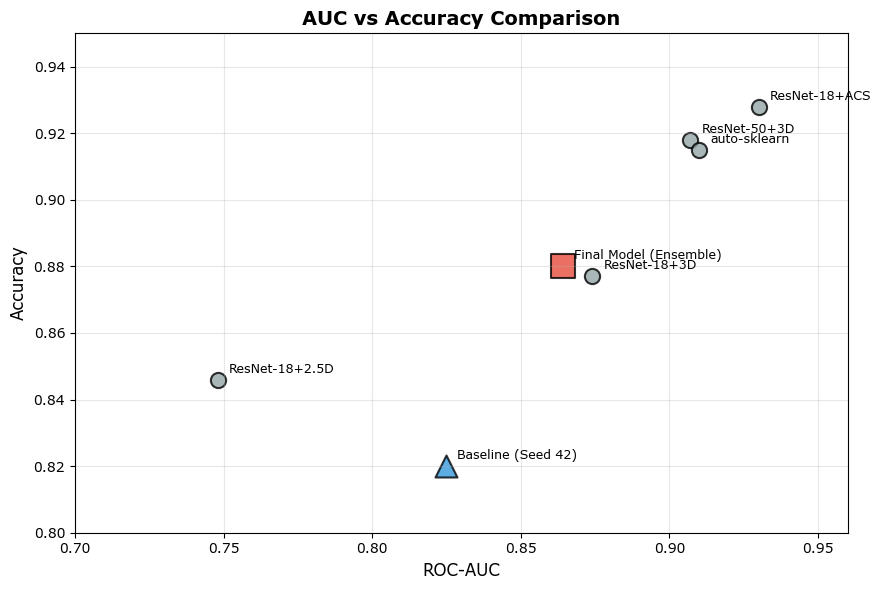

In [ ]:
# ============================================================
# 5. AUC vs Accuracy Scatter 
# ============================================================
plt.figure(figsize=(9, 6))
for i, (method, auc, acc) in enumerate(zip(benchmark_methods, benchmark_aucs, benchmark_accs)):
    if 'Final' in method:
        color, size, marker = '#e74c3c', 300, 's'  # Red square for final
    elif 'Baseline' in method:
        color, size, marker = '#3498db', 250, '^'  # Blue triangle for baseline
    else:
        color, size, marker = '#95a5a6', 120, 'o'  # Gray circle for others
    plt.scatter(auc, acc, s=size, c=color, alpha=0.8, edgecolors='black', 
                linewidths=1.5, marker=marker)
    plt.annotate(method, (auc, acc), textcoords="offset points", 
                 xytext=(8, 5), ha='left', fontsize=9)
plt.xlabel('ROC-AUC', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('AUC vs Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlim(0.7, 0.96)
plt.ylim(0.80, 0.95)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('5_auc_vs_accuracy.png', dpi=150)
plt.show()



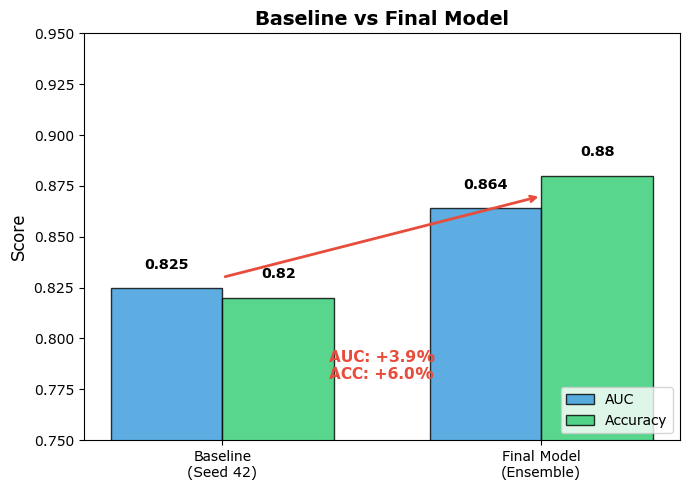

In [14]:
# ============================================================
# 6. Baseline vs Final Model
# ============================================================
plt.figure(figsize=(7, 5))
comparison = ['Baseline\n(Seed 42)', 'Final Model\n(Ensemble)']
aucs = [0.8247, 0.8642]
accs = [0.82, 0.88]

x = np.arange(len(comparison))
width = 0.35

bars_auc = plt.bar(x - width/2, aucs, width, label='AUC', color='#3498db', edgecolor='black', alpha=0.8)
bars_acc = plt.bar(x + width/2, accs, width, label='Accuracy', color='#2ecc71', edgecolor='black', alpha=0.8)

plt.ylabel('Score', fontsize=12)
plt.title('Baseline vs Final Model', fontsize=14, fontweight='bold')
plt.xticks(x, comparison)
plt.ylim(0.75, 0.95)
plt.legend(loc='lower right')

for bar in bars_auc:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008, 
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar in bars_acc:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add improvement annotation
plt.annotate('', xy=(1, 0.87), xytext=(0, 0.83),
            arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=2))
plt.text(0.5, 0.78, f'AUC: +{(aucs[1]-aucs[0])*100:.1f}%\nACC: +{(accs[1]-accs[0])*100:.1f}%', 
         ha='center', fontsize=11, color='#e74c3c', fontweight='bold')

plt.tight_layout()
# plt.savefig('6_baseline_vs_final.png', dpi=150)
plt.show()

